# View, Compare, and Share Experiment Results

In [3]:
from pyspark.sql import SparkSession
from splicemachine.spark import PySpliceContext
from splicemachine.mlflow_support import *

# Setup
spark = SparkSession.builder.getOrCreate()
splice = PySpliceContext(spark)
mlflow.register_splice_context(splice)

## Load in our Data

In [4]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

iris = load_iris()
cols = [i.rstrip(' (cm)').replace(' ','_') for i in iris['feature_names']] + ['label']

pdf = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= cols)

# Convert integer labels to meaningful labels
pdf['Species'] = pdf['label'].map({i:iris.target_names[i] for i in range(3)}).astype('str')
pdf.head()
df = spark.createDataFrame(pdf)
df.show()

+------------+-----------+------------+-----------+-----+-------+
|sepal_length|sepal_width|petal_length|petal_width|label|Species|
+------------+-----------+------------+-----------+-----+-------+
|         5.1|        3.5|         1.4|        0.2|  0.0| setosa|
|         4.9|        3.0|         1.4|        0.2|  0.0| setosa|
|         4.7|        3.2|         1.3|        0.2|  0.0| setosa|
|         4.6|        3.1|         1.5|        0.2|  0.0| setosa|
|         5.0|        3.6|         1.4|        0.2|  0.0| setosa|
|         5.4|        3.9|         1.7|        0.4|  0.0| setosa|
|         4.6|        3.4|         1.4|        0.3|  0.0| setosa|
|         5.0|        3.4|         1.5|        0.2|  0.0| setosa|
|         4.4|        2.9|         1.4|        0.2|  0.0| setosa|
|         4.9|        3.1|         1.5|        0.1|  0.0| setosa|
|         5.4|        3.7|         1.5|        0.2|  0.0| setosa|
|         4.8|        3.4|         1.6|        0.2|  0.0| setosa|
|         

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline

!jupyter nbconvert --to html "MLflow Tracking.ipynb"
# Set our experiment for tracking
mlflow.set_experiment('Iris Testing')

va = VectorAssembler(inputCols=df.columns[:4], outputCol='features')
dt = DecisionTreeClassifier()
pipe = Pipeline(stages=[va,dt])

with mlflow.start_run(run_name='DT_run'):
    # Log entire Spark Pipeline
    mlflow.log_pipeline_stages(pipe)
    # Log entire feature transformation
    mlflow.log_feature_transformations(pipe)
    # Log training time
    with mlflow.timer('train_time'):
        model = pipe.fit(df)

    # Save our model (library, version etc saved automatically)
    mlflow.log_model(model, "decision_tree_model")
    # Save notebook for viewing
    mlflow.log_artifact('MLflow Tracking.html', 'MLflow Tracking.html')
    
    #gather some info
    run_id = mlflow.current_run_id()
    exp_id = mlflow.current_exp_id()
    

In [ ]:
get_mlflow_ui(experiment_id=exp_id, run_id=run_id)

## Artifact Storage

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from splicemachine.notebook import hide_toggle
import matplotlib.pyplot as plt

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    
    
def plot_roc(points):
    plt.figure()
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    plt.title('RoC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(x_val, y_val)
    plt.savefig('RoC.png')
    
hide_toggle()

[NbConvertApp] Converting notebook MLflow Tracking.ipynb to html
[NbConvertApp] Writing 323349 bytes to MLflow Tracking.html
Starting Code Block train_time... Done.
Code Block train_time:
Ran in 3.28 secs
Ran in 0.055 mins


<IPython.core.display.Javascript object>

Saving artifact of size: 9.982 KB to Splice Machine DB
Saving artifact of size: 323.406 KB to Splice Machine DB
Saving artifact of size: 13.035 KB to Splice Machine DB


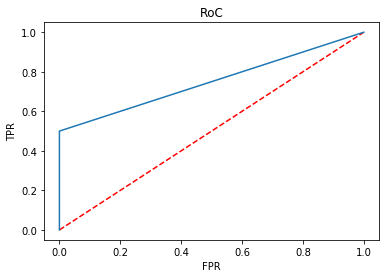

In [52]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline
from IPython.display import display, Javascript
from time import sleep

!jupyter nbconvert --to html "MLflow Tracking.ipynb"
# Set our experiment for tracking
mlflow.set_experiment('Iris Testing')

va = VectorAssembler(inputCols=df.columns[:4], outputCol='features')
lr = LogisticRegression()
pipe = Pipeline(stages=[va,lr])

with mlflow.start_run(run_name='LR Run'):
    # Log entire Spark Pipeline
    mlflow.log_pipeline_stages(pipe)
    # Log entire feature transformation
    mlflow.log_feature_transformations(pipe)
    
    train,test = df.randomSplit([0.8,0.2])
    # Log training time
    with mlflow.timer('train_time'):
        model = pipe.fit(train)
    
    predictions = model.transform(test).select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    points = CurveMetrics(preds).get_curve('roc')
    plot_roc(points)
    
    display(Javascript('IPython.notebook.save_checkpoint();'))
    
    # Log our artifacts
    mlflow.log_model(model, "lr_model")
    mlflow.log_artifact('MLflow Tracking.html', 'MLflow Tracking.html')
    mlflow.log_artifact('RoC.png','RoC.png')

    
    #gather some info
    run_id = mlflow.current_run_id()
    exp_id = mlflow.current_exp_id()    

In [53]:
get_mlflow_ui(exp_id, run_id)

## Storing to GitHub

In [ ]:
from IPython.display import display, Javascript

# Save our notebook
display(Javascript('IPython.notebook.save_checkpoint();'))

!git add .
!git commit -m "first pass model complete with RoC"
!git push